**Instructions:**

- For questions that require coding, you need to write the relevant code and display its output. Your output should either be the direct answer to the question or clearly display the answer in it.
- For questions that require a written answer (sometimes along with the code), you need to put your answer in a Markdown cell. Writing the answer as a comment or as a print line is not acceptable.
- You need to render this file as HTML using Quarto and submit the HTML file. **Please note that this is a requirement and not optional.** A submission cannot be graded until it is properly rendered.

Import all the libraries and tools you need below.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_circles
from sklearn.cluster import KMeans

Run the cell given below to create and plot two different two-dimensional datasets:

- The first dataset has four blobs that come from different Gaussian distributions. Assume that each blob is a cluster.
- The second dataset has two concentric circles centered at the origin. Assume that each circle is a cluster.

**Note:** In this in-class assignment and the next, you will work on these toy datasets to understand both the scikit-learn tools and the Expectation-Maximization (EM) algorithm better. In Homework Assignment 3, you will apply clustering to real-life datasets.

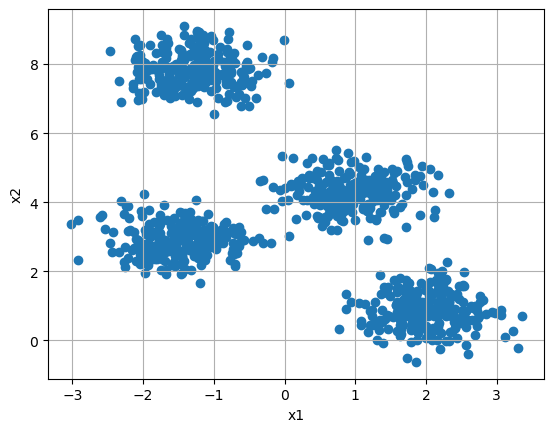

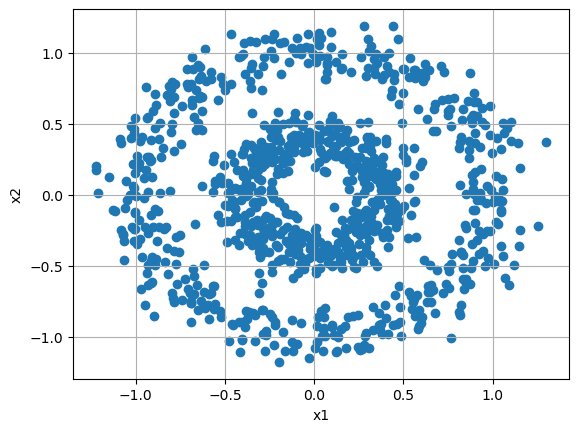

In [2]:
n_samples = 1000
n_components = 4

X_blob, true_labels_blob = make_blobs(n_samples=n_samples, centers=4, cluster_std=0.50, random_state=0)
X_circ, true_labels_circ = make_circles(n_samples=n_samples, noise=0.1, random_state=0,factor=0.4)

plt.scatter(X_blob[:,0],X_blob[:,1])
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

plt.scatter(X_circ[:,0],X_circ[:,1])
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## 1)

Create and train two [K-Means](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html) models, one for each dataset. For both models, use `random_state=1` for reproducible initialization. Note that you need to pick a proper `n_clusters`. Leave the other inputs default. **(10 points)**

In [3]:
# Create two K-Means models
K_Means_1 = KMeans(n_clusters = 4, random_state = 1)
K_Means_2 = KMeans(n_clusters = 2, random_state = 1)

## 2)

Using the trained models, obtain the predicted cluster labels. Plot both datasets again, only this time, color code the observations with the **predicted** labels.

**Note:** If you are not familiar with data visualization in Python, the lines in the given cell above should be helpful. Just keep in mind that `plt.scatter` function has a `c` input for color-coding.

**(10 points)**

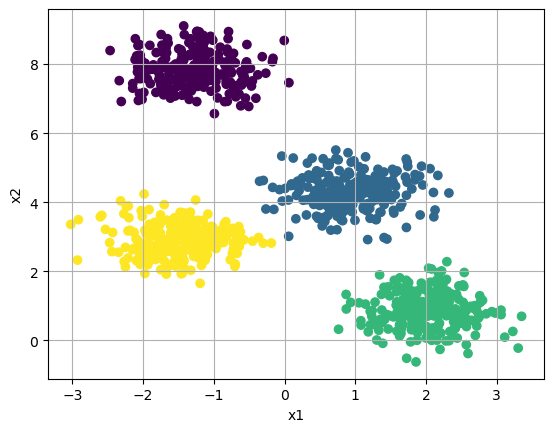

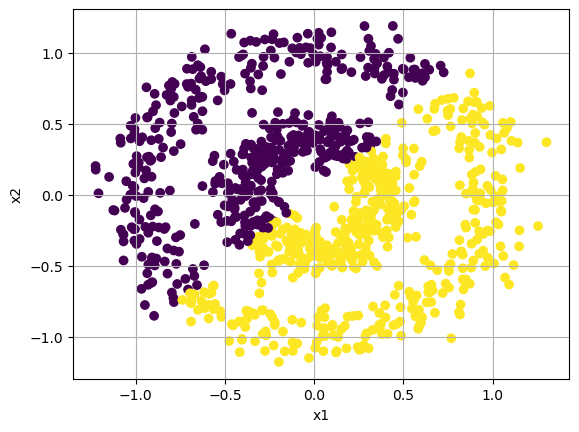

In [4]:
# Obtain the cluster labels through fitting
cluster_label_1 = K_Means_1.fit(X_blob)
cluster_label_2 = K_Means_2.fit(X_circ)

# Color code the obs
plt.scatter(X_blob[:,0],X_blob[:,1], c = cluster_label_1.labels_)
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

plt.scatter(X_circ[:,0],X_circ[:,1], c = cluster_label_2.labels_)
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## 3)

Does the K-Means model properly find the clusters in both datasets? Does it fail in any dataset? Why or why not? **Your explanation should include the (only) assumption behind a K-Means model for credit.** **(10 points)**

The K-means model could not find the proper cluster for the circular dataset (The second picture) since the distribution of data is not based on Gassian Distribution; therefore, the algorithm of K-Means finding the centroid and evaluating classes/ clusters of each specific data point by calculating distance fails to properly divide data into appropriate clusters.

## 4)

In this question, you will write the two functions that implement the EM algorithm. You will bring them together in the next in-class assignment.

### a)

Define a function called `M_step`. It should take two inputs: (1) `X`, the variable matrix and (2) `cluster_preds`, the vector of predicted cluster labels.

For each cluster label, the function should calculate the centroid by taking variable averages. 

The function should return the calculated centroid values for each cluster label, **as a two-dimensional numpy array**. The size of the array should be: **(number of cluster labels, number of variables).**


**You are not allowed to use loops/comprehensions.** The implementation should be vectorized. Consider the following steps:
- Concatenate X and the labels and convert the output to a DataFrame.
- [Group by](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) the last column.
- Return the group averages, converted back to a numpy array.

**(30 points)**

In [30]:
# Define M_step
def M_step(X, cluster_preds):
    # Change X, cluster_preds to dataframe
    X = pd.DataFrame(X)
    cluster_preds = pd.DataFrame(cluster_preds, columns = ['cluster'])
    # Concat
    X_concat = pd.DataFrame(pd.concat([X, cluster_preds], axis = 1))
    # group the data by clusters
    X_concat = X_concat.groupby(['cluster'])
    # Change back to array
    return np.array(X_concat.mean())


In [32]:
toy_X = np.arange(1,37).reshape(9,4)
toy_labels = np.array([0,1,2,0,1,2,0,1,2])


M_step(toy_X, toy_labels)

# should return: 

#array([[13., 14., 15., 16.],
#       [17., 18., 19., 20.],
#       [21., 22., 23., 24.]])

array([[13., 14., 15., 16.],
       [17., 18., 19., 20.],
       [21., 22., 23., 24.]])

### b)

Define a function called `E_step`. It should take two inputs: (1) `X`, the variable matrix and (2) `centroids`, the matrix of predicted centroids.

For each observation, the function should calculate the cluster label by finding the closest centroid. The function should return the predicted cluster labels for each observation, **as a one-dimensional numpy array**. The size of the array should be: **(number of observations, )**.

**You are not allowed to use loops/comprehensions.** The implementation should be vectorized. Consider the following steps:
- Convert X to a DataFrame.
- To each row, [apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) a function that finds the Euclidean distance to each row of `centroids` and returns the row index with the smallest distance. (You can implement this with a lambda function or define another function.)
- Convert the output to a numpy array.

**(40 points)**

In [42]:
# Define E_step
def E_step(X, centroids):
    # Convert X to dataframe
    X = pd.DataFrame(X)
    # Get the centroids into dataframe
    centroids = pd.DataFrame(centroids)
    # Apply the function fot finding Euclidean distance
    # Function to calculate Euclidean distances and return the index of the closest centroid
    def closest_centroid(row):
        # Numpy automatically boosts the size of row to match with centroids
        distances = np.linalg.norm(centroids.values - row.values, axis=1)
        # Smallest distance among the array, return indices
        return np.argmin(distances)
    
    # Apply the function to each row in X_df (set axis = 1 for apply)
    cluster_labels = X.apply(closest_centroid, axis=1)
    return np.array(cluster_labels)



In [43]:
toy_X = np.arange(1,37).reshape(9,4)
toy_centroids = np.array([[13., 14., 15., 16.],
                           [17., 18., 19., 20.],
                           [21., 22., 23., 24.]])

E_step(toy_X, toy_centroids)

# should return:
    # array([0, 0, 0, 0, 1, 2, 2, 2, 2]

array([0, 0, 0, 0, 1, 2, 2, 2, 2])